# Part-of-Speech Tagging with Recurrent Neural Networks

Your task in this assignment is to implement a simple part-of-speech tagger based on recurrent neural networks.

## Get a graphics card

Skip this part if you run on a CPU

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

## Problem specification

Your task in this assignment is

1. to build a part-of-speech tagger based on a recurrent neural network architecture
2. to train this tagger on the provided training data and identify a good model
2. to evaluate the performance of this model on the provided test data

To identify a good model, you can use the provided development (validation) data.

## Part-of-speech tagging

Part-of-speech (POS) tagging is the task of labelling words (tokens) with [parts of speech](https://en.wikipedia.org/wiki/Part_of_speech). To give an example, consider the  sentence *Parker hates parsnips*. In this sentence, the word *Parker* should be labelled as a proper noun (a noun that is the name of a person), *hates* should be labelled as a verb, and *parsnips* should be labelled as a (common) noun. Part-of-speech tagging is an essential ingredient of many state-of-the-art natural language understanding systems.

Part-of-speech tagging can be cast as a supervised machine learning problem where the gold-standard data consists of sentences whose words have been manually annotated with parts of speech. For the present assignment you will be using a corpus built over the source material of the [English Web Treebank](https://catalog.ldc.upenn.edu/LDC2012T13), consisting of approximately 16,000&nbsp;sentences with 254,000&nbsp;tokens. The corpus has been released by the [Universal Dependencies Project](http://universaldependencies.org).

To make it easier to compare systems, the gold-standard data has been split into three parts: training, development (validation), and test. The following cell provides a function that can be used to load the data.

In [20]:
def read_data(path):
    with open(path, encoding='utf-8') as fp:
        result = []
        for line in fp:
            line = line.rstrip()
            if len(line) == 0:
                yield result
                result = []
            elif not line.startswith('#'):
                columns = line.split()
                if columns[0].isdigit():
                    result.append((columns[1], columns[3]))

The next cell loads the data:

In [21]:
train_data = list(read_data('en_ewt-ud-train.conllu'))
print('Number of sentences in the training data: {}'.format(len(train_data)))

dev_data = list(read_data('en_ewt-ud-dev.conllu'))
print('Number of sentences in the development data: {}'.format(len(dev_data)))

test_data = list(read_data('en_ewt-ud-test.conllu'))
print('Number of sentences in the test data: {}'.format(len(test_data)))

Number of sentences in the training data: 12543
Number of sentences in the development data: 2001
Number of sentences in the test data: 2077


From a Python perspective, each of the data sets is a list of what we shall refer to as *tagged sentences*. A tagged sentence, in turn, is a list of pairs $(w,t)$, where $w$ is a word token and $t$ is the word&rsquo;s POS tag. Here is an example from the training data to show you how this looks like:

In [3]:
train_data[42]

[('There', 'PRON'),
 ('has', 'AUX'),
 ('been', 'VERB'),
 ('talk', 'NOUN'),
 ('that', 'SCONJ'),
 ('the', 'DET'),
 ('night', 'NOUN'),
 ('curfew', 'NOUN'),
 ('might', 'AUX'),
 ('be', 'AUX'),
 ('implemented', 'VERB'),
 ('again', 'ADV'),
 ('.', 'PUNCT')]

You will see part-of-speech tags such as `VERB` for verb, `NOUN` for noun, and `ADV` for adverb. If you are interested in learning more about the tag set used in the gold-standard data, you can have a look at the documentation of the [Universal POS tags](http://universaldependencies.org/u/pos/all.html). However, you do not need to understand the meaning of the POS tags to solve this assignment; you can simply treat them as labels drawn from a finite set of alternatives.

## Network architecture

The proposed network architecture for your tagger is a sequential model with three layers, illustrated below: an embedding, a bidirectional LSTM, and a softmax layer. The embedding turns word indexes (integers representing words) into fixed-size dense vectors which are then fed into the bidirectional LSTM. The output of the LSTM at each position of the sentence is passed to a softmax layer which predicts the POS tag for the word at that position.

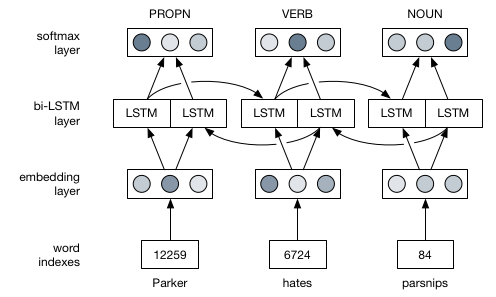

To implement the network architecture, you will use [Keras](https://keras.io/). Keras comes with an extensive online documentation, and reading the relevant parts of this documentation will be essential when working on this assignment. We suggest to start with the tutorial [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/). After that, you should have a look at some of the examples mentioned in that tutorial, and in particular the [Bidirectional LSTM](https://keras.io/examples/nlp/bidirectional_lstm_imdb/) example.

## Evaluation

The most widely-used evaluation measure for part-of-speech tagging is per-word accuracy, which is the percentage of words to which the tagger assigns the correct tag (according to the gold standard). This is one of the default metrics in Keras.

One problem that you will encounter during evaluation is that the evaluation data contains words that you did not see (and did not add to your index) during training. The simplest solution to this problem is to introduce a special &lsquo;word&rsquo; `<unk>` and replace each unknown word with this pseudoword.

## Part 1: Pre-process the data

Before you can start to implement the network architecture as such, you will have to bring the tagged sentences from the gold-standard data into a form that can be used with the network. One important step in this is to map the words and tags (strings) to integers. Here is code that illustrates the idea:

In [22]:
word_to_index = {}
for tagged_sentence in train_data:
    for word, tag in tagged_sentence:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

print('Number of unique words in the training data: {}'.format(len(word_to_index)))
print('Index of the word "hates": {}'.format(word_to_index['hates']))

Number of unique words in the training data: 19673
Index of the word "hates": 4579


Once you have indexes for the words and the tags, you can construct the input and the gold-standard output tensor required to train the network.

### Constructing the input tensor

The input tensor should be of shape $(N, n)$ where $N$ is the total number of sentences in the training data and $n$ is the length of the longest sentence. Note that Keras requires all sequences in an input tensor to have the same length, which means that you will have to pad all sequences to that length. You can use the helper function [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) for this, which by default will front-pad sequences with the value&nbsp;0. It is essential then that you do not use this special padding value as the index of actual words.

### Constructing the target output tensor

The target output tensor should be of shape $(N, n, T)$ where $T$ is the number of unique tags in the training data, plus one to cater for the special padding value. The additional dimension corresponds to the fact that the softmax layer of the network will output one $T$-dimensional vector for each position of an input sentence. To construct this vector, you can use the helper function [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [23]:
# Define a help function to build index from a list of words or tags, each word / tag will have a unique number
def build_index(strings, init=[]):
    string_to_index = {s: i for i, s in enumerate(init)}
    # Loop over strings in 'strings'
    for strs in strings:       
        # Check if string exists in variable 'string_to_index', 
        # if string does not exist, add a new element to 'string_to_index': the current length of 'string_to_index'
        if strs not in string_to_index:
            string_to_index[strs] = len(string_to_index)
        
    return string_to_index
        
# Convert all words and tags in train_data to lists, start with empty lists and use '.append()' 
# to add one word / tag at a time, similar to the cell below 'pre-process the data'
words, tags = [], []
for tagged_sentence in train_data:
    for word, tag in tagged_sentence:
        words.append(word), tags.append(tag)

# Call the help function you made, to build an index for words (word_to_index), and one index for tags (tag_to_index)
word_to_index = build_index(words, ['<pad>', '<unk>'])
tag_to_index = build_index(tags, ['<pad>'])


# Check number of words and tags
num_words = len(word_to_index)
num_tags = len(tag_to_index)

print(f'Number of unique words in the training data: {num_words}')
print(f'Number of unique tags in the training_data: {num_tags}')

# You should get 19674 unique words and 18 unique tags (17 universal POS tags + padding) 
# '<pad>' should be included as a tag. (Hint: init in build_index)
# '<pad>' and '<unk>' (unknown) should be included as words (Hint: init in build_index)


Number of unique words in the training data: 19675
Number of unique tags in the training_data: 18


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Make a function that converts the tagged sentences, word indices and tag indices to 
# X and Y, that can be used when training the RNN
def encode(tagged_sentences, word_to_index, tag_to_index):
    
    # Start with empty lists that will contain all training examples and corresponding output
    X, Y = [], []
    
    # Loop over tagged sentences
    for current_sentence in tagged_sentences:
    
        # Make empty lists for current sentence
        Xcurrent, Ycurrent = [], []
    
        # Loop over words and tags in current sentence
        for word, tag in current_sentence:
            
             # Append the index for the current word to Xcurrent, 
             # if the word does not exist in 'word_to_index', add the index for '<unk>' instead
            if word not in word_to_index:
                Xcurrent.append(word_to_index['<unk>'])
            else:
                Xcurrent.append(word_to_index[word])
             # Append the index for the current tag to Ycurrent
            Ycurrent.append(tag_to_index[tag])
                
        # Append X with Xcurrent, and Y with Ycurrent
        X.append(Xcurrent), Y.append(Ycurrent)
    # Pad the sequences, so that all have the same length
    X, Y = pad_sequences(X), pad_sequences(Y)
    # Convert labels to categorical, as you did in the CNN lab
    Y = to_categorical(Y, num_classes=num_tags, dtype="float32")
    return X, Y
    
    
    
# Use your 'encode' function to create Xtrain and Ytrain from train_data, word_to_index, tag_to_index
Xtrain, Ytrain = encode(train_data, word_to_index, tag_to_index)


# Print the shape of Xtrain and Ytrain
print(Xtrain.shape)
print(Ytrain.shape)

# The shapes should be
# (12543, 159)
# (12543, 159, 18)

(12543, 159)
(12543, 159, 18)


## Part 2: Construct the model

To implement the network architecture, you need to find and instantiate the relevant building blocks from the Keras library. Note that Keras layers support a large number of optional parameters; use the default values unless you have a good reason not to. Two mandatory parameters that you will have to specify are the dimensionality of the embedding and the dimensionality of the output of the LSTM layer. The following values are reasonable starting points, but do try a number of different settings.

* dimensionality of the embedding: 100
* dimensionality of the output of the bidirectional LSTM layer: 100

You will also have to choose an appropriate loss function for MULTI-class classification (18 classes). For training we recommend the Adam optimiser.

In [50]:
from tensorflow.keras import Sequential
# Import necessary layers
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

embedding_dim = 80 # 5% ish
hidden_dim = 120
max_features = 19675 # Vocabulary of X unqiue words # num_words
optimizer = Adam()
loss_function = CategoricalCrossentropy()

def build_RNN():

    # Create model, similar to how it was done in the DNN and CNN labs
    model = Sequential()

    # The model should have an embedding layer, a bidirectional LSTM, and a dense softmax layer 
    # (see the network architecture image)
    
    # Embedding layer
    model.add(Embedding(input_dim=max_features, # Number of words in the training data = 12543
                        output_dim=embedding_dim, # Length of vector representation = 100
                        mask_zero=True)) # Boolean, whether or not the input value 0 is a special "padding" value that should be masked out
             
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(hidden_dim, # hidden_dim = 100
                                return_sequences=True))) # Whether to return the last output in the output sequence, or the full sequence
    
    # Dense layer
    model.add(Dense(units=num_tags, # Number of class labels = 18
                    activation='softmax')) # Activation function = softmax

    # Compile model with loss function
    model.compile(optimizer=optimizer, # Adam()
                  loss=loss_function, # CategoricalCrossentropy
                  metrics=['accuracy'])

    # Return the model
    return model

## Part 3: Train the network

The next step is to train the network. Use the following parameters:

* number of epochs: 10
* batch size: 32

Training will print the average running loss on the training data after each minibatch. In addition to that, we ask you to also print the loss and accuracy on the development data after each epoch. You can do so by providing the `validation_data` argument to the `fit` method.

Note that the `fit` method returns a [`History`](https://keras.io/callbacks/#history) object that contains useful information about the training. We will use that information in the next step.

In [51]:
# Encode the development (validation data) using the 'encode' function you created before, to get Xval and Yval
Xvali, Yvali = encode(dev_data, word_to_index, tag_to_index)
model1 = build_RNN()
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 80)          1574000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 240)        192960    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, None, 18)          4338      
                                                                 
Total params: 1,771,298
Trainable params: 1,771,298
Non-trainable params: 0
_________________________________________________________________


In [65]:
import keras
import tensorflow as tf

epochs = 10
batch_size = 128

# Train the model and save the history, as you did in the DNN and CNN labs, provide validation data

history = model1.fit(Xtrain, Ytrain, validation_data=(Xvali, Yvali), epochs = epochs, batch_size = batch_size)

Epoch 1/10
251/251 [==============================] - 49s 197ms/step - loss: 0.0012 - accuracy: 0.9972 - val_loss: 0.0844 - val_accuracy: 0.8976
Epoch 2/10
251/251 [==============================] - 50s 198ms/step - loss: 0.0017 - accuracy: 0.9952 - val_loss: 0.0913 - val_accuracy: 0.8965
Epoch 3/10
251/251 [==============================] - 50s 200ms/step - loss: 0.0010 - accuracy: 0.9971 - val_loss: 0.0931 - val_accuracy: 0.8967
Epoch 4/10
251/251 [==============================] - 50s 198ms/step - loss: 5.1470e-04 - accuracy: 0.9990 - val_loss: 0.0982 - val_accuracy: 0.8986
Epoch 5/10
251/251 [==============================] - 50s 200ms/step - loss: 3.0918e-04 - accuracy: 0.9996 - val_loss: 0.0938 - val_accuracy: 0.8985
Epoch 6/10
251/251 [==============================] - 50s 200ms/step - loss: 2.1789e-04 - accuracy: 0.9997 - val_loss: 0.1000 - val_accuracy: 0.8989
Epoch 7/10
251/251 [==============================] - 52s 207ms/step - loss: 1.6389e-04 - accuracy: 0.9998 - val_loss:

KeyboardInterrupt: 

## Part 4: Identify a good model

The following code will plot the loss on the training data and the loss on the validation data after each epoch:

In [61]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt

def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

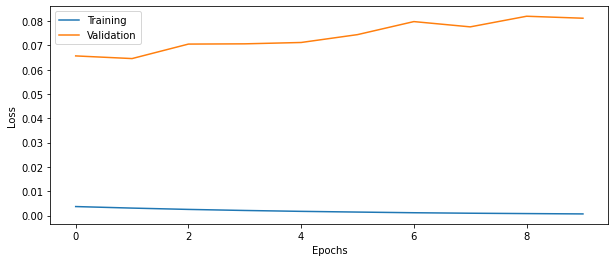

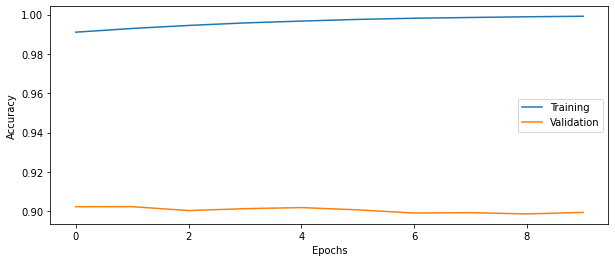

In [69]:
# Withouth early stopping
plot_results(history)

# The retrained model with implementing the early stopping.

In [68]:
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

epochs = 10
batch_size = 128

# Early stopping, 0 patience
es = EarlyStopping(monitor='val_loss', mode='min', patience = 1)
# Train the model and save the history, as you did in the DNN and CNN labs, provide validation data
history2 = model1.fit(Xtrain, Ytrain, validation_data=(Xvali, Yvali), epochs = epochs, batch_size = batch_size,
                     callbacks = [es])

Epoch 1/10
98/98 [==============================] - 42s 426ms/step - loss: 8.7845e-05 - accuracy: 0.9998 - val_loss: 0.0987 - val_accuracy: 0.9006
Epoch 2/10
98/98 [==============================] - 36s 366ms/step - loss: 8.2803e-05 - accuracy: 0.9999 - val_loss: 0.1039 - val_accuracy: 0.8998


Look at the plot and determine the epoch after which the model starts to overfit. Then, re-train your model using that many epochs and compute the accuracy of the tagger on the test data.

In [70]:
# Encode the test_data using the 'encode' function you created before, to get Xtest and Ytest
Xtest, Ytest = encode(test_data, word_to_index, tag_to_index)

# Evaluate the model on test data, as you did in the DNN and CNN lab
score = model1.evaluate(Xtest, Ytest)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

65/65 [==============================] - 1s 20ms/step - loss: 0.0883 - accuracy: 0.8970
Test loss: 0.0883
Test accuracy: 0.8970


## Submission

Your notebook should include all your code, and should be runnable without further modification. It should also include answers to the following questions:

How many epochs did you train the final model for?

What accuracy did you achieve on the test data?

What dimensionality of the embedding did you use for your best results?

What dimensionality of the output of the bidirectional LSTM layer did you use for your best results?

Instead of manually identifying a good model, and redoing the training to that number of epochs, how can you automatically stop the training when the validation performance does not improve anymore? Hint: see Lecture 2

What did you find particularly surprising or hard?

How do you calculate the number of parameters in the embedding layer? Hint: the calculation includes the vocabulary size and the embedding dimension

How do you calculate the number of parameters in the bidirectional LSTM layer? Hint: A LSTM layer has 4 parts; cell, input gate, output gate, forget gate, each part contains two weight matrices and a bias vector. A bidirectional LSTM contains two LSTMs.

https://en.wikipedia.org/wiki/Long_short-term_memory

1. Used patience = 1, allowing it to run for one more epoch after not improving validation loss. It ran for 3 epochs.

2. 89.70%

3. 80

4. 120

5. We can implement early stopping in keras by using the `callback = [es]` argument where `es = EarlyStopping()`, where we monitor the validation loss and stop the training when the validation loss stops decreasing.

6. I was stuck a while on passing the correct arguments to the embedding and lstm layer, as I didn't provide the network with the necessary parameters (return sequence and mask zero).

7. Vocabulary size * Embedding dim = n_parameters in embedding layer

8. (dimension of input vector + number of LSTM units + 1 bias) * 4 LSTM parts * number of LSTM * number of LSTM units = number of parameters in bidirectional LSTM layer
(80 + 120 + 1) * 4 * 2 * 120 = 192960

## Ethics in deep learning

Now that you have watched the 5 lectures, and completed the 3 laborations in this course, what do you think is the most important ethical question related to deep learning? Motivate your answer.



What is becoming much more apparent after working with the material in this course is how relatively easy it is to create fake/augment data, and even if it's somewhat lacking in being 100% realistic it can still be persuasive at first glance. Therefor you as a developer/coder have a responsibility to be carefull when producing new material, as it's rather easy for someone with ill intentions to label it according to their agenda and market it as such. The ethical aspect in this is department is, amongst many other things, to be carefull with what software you create and be thoughtfull before releasing it.